In [14]:
%reset -f

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os 
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow.keras.backend as K

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.constraints import NonNeg
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from utils.NNSIF_model import get_prediction_model, get_trainable_model, layer_output, fluxes_SIF_predict
from utils.preprocess import include_predictions, div_daynight, standard_x, split_train_test
from utils.plot import regression_line, GPP_SIF_dependence


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13

### 1. import & preprocess the data

In [2]:
os.chdir('/Users/weiweizhan/Desktop/Weiwei_Zhan/Projects/SIF_partition/DATA/')

data_NN = pd.read_csv('./FinalData/test_data_SCOPE.csv',index_col=0)
data_NN.index = pd.to_datetime(data_NN.index)


In [3]:
train_dataset, test_dataset, NEE_norm, SIF_norm = split_train_test(data_NN,seed=31,
                                                   EV1_label = ['Tair','RH','SWC','PAR','u','LAI'], 
                                                   EV2_label = ['Tair','SWC','u','LAI'], 
                                                   EV3_label = ['Tair','RH','SWC'],
                                                   var_NEE = 'NEE_canopy', var_SIF = 'SIFcanopy_760nm',
                                                   flux_label = ['GPP_canopy','Reco_canopy','Reco_NT','GPP_NT','Reco_DT','GPP_DT'])

train,EV1_train1,EV2_train1,EV3_train1,NEE_train1,SIF_train1,flux_train,label_train = train_dataset
test, EV1_test1, EV2_test1, EV3_test1, NEE_test, SIF_test, flux_test, label_test  = test_dataset



### 2. train the $NN_{SIF}$ model

In [4]:
prediction_model = get_prediction_model(n_neuron=64,
                                        input1_shape=EV1_train1.shape[1],
                                        input2_shape=EV2_train1.shape[1],
                                        input3_shape=EV3_train1.shape[1])
trainable_model  = get_trainable_model(prediction_model,
                                       input1_shape=EV1_train1.shape[1],
                                       input2_shape=EV2_train1.shape[1],
                                       input3_shape=EV3_train1.shape[1])

optimizer1 = keras.optimizers.Adam(lr=0.002)
trainable_model.compile(optimizer=optimizer1, loss=None)

assert len(trainable_model.layers[-1].trainable_weights) == 2  
assert len(trainable_model.losses) == 1

hist = trainable_model.fit([label_train,EV1_train1,EV2_train1,EV3_train1,NEE_train1,SIF_train1], 
                            epochs=60, batch_size=64, verbose=1,validation_split = 0.3)

Train on 3210 samples, validate on 1376 samples
Epoch 1/60
3210/3210 [==============================] - 0s 52us/sample - loss: 0.0080 - mse_nee: 0.0668 - mse_sif: 0.0344 - val_loss: -0.1977 - val_mse_nee: 0.0066 - val_mse_sif: 0.0049
Epoch 2/60
3210/3210 [==============================] - 0s 35us/sample - loss: -0.3031 - mse_nee: 0.0050 - mse_sif: 0.0029 - val_loss: -0.4136 - val_mse_nee: 0.0041 - val_mse_sif: 0.0017
Epoch 3/60
3210/3210 [==============================] - 0s 33us/sample - loss: -0.5144 - mse_nee: 0.0035 - mse_sif: 0.0016 - val_loss: -0.6218 - val_mse_nee: 0.0033 - val_mse_sif: 0.0015
Epoch 4/60
3210/3210 [==============================] - 0s 36us/sample - loss: -0.7217 - mse_nee: 0.0029 - mse_sif: 0.0015 - val_loss: -0.8285 - val_mse_nee: 0.0033 - val_mse_sif: 9.7817e-04
Epoch 5/60
3210/3210 [==============================] - 0s 35us/sample - loss: -0.9285 - mse_nee: 0.0026 - mse_sif: 0.0010 - val_loss: -1.0349 - val_mse_nee: 0.0027 - val_mse_sif: 9.1668e-04
Epoch 6/60

### 3. predict carbon fluxes using the well-trained model

In [5]:
NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN = fluxes_SIF_predict(prediction_model,label_train,
                                                                         EV1_train1, EV2_train1, EV3_train1,
                                                                         NEE_norm, SIF_norm)
NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN = fluxes_SIF_predict(prediction_model,label_test,
                                                                     EV1_test1, EV2_test1, EV3_test1,
                                                                     NEE_norm, SIF_norm)



train = include_predictions(train,NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN)
test  = include_predictions(test,NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN)

# save the data
data_NN = pd.concat([train,test],axis=0).sort_index()
day_SC, night_SC = div_daynight(data_NN)

### 4. evaluate the model predictions

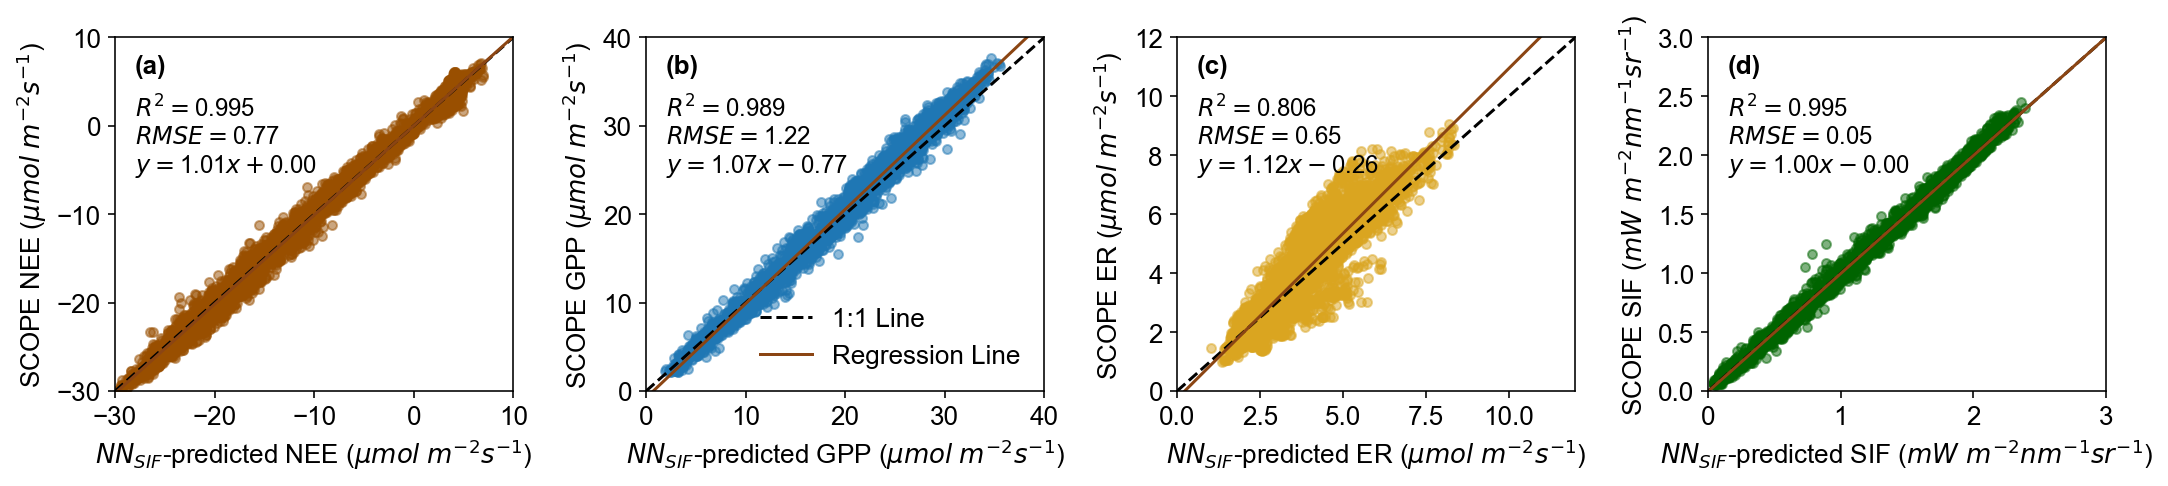

In [6]:
fig, axes = plt.subplots(figsize=(15,3.5),ncols=4)

c_GPP,c_Reco = 'tab:blue','goldenrod'
c_NEE,c_SIF  = '#994F00','darkgreen'


xlim1,ylim1 = [-30,10], [-30,10]
xlim2,ylim2 = [0,40],[0,40]
xlim3,ylim3 = [0,12], [0,12]
xlim4,ylim4 = [0,3.], [0,3.]


data_NN.plot('NEE_NN','NEE_canopy',kind='scatter',ax=axes[0],alpha=0.5,xlim=xlim1,ylim=ylim1,c=c_NEE)
day_SC.plot('GPP_NN','GPP_canopy',kind='scatter',ax=axes[1],alpha=0.5,xlim=xlim2,ylim=ylim2,c=c_GPP) 
data_NN.plot('Reco_NN','Reco_canopy',kind='scatter',ax=axes[2],alpha=0.5,xlim=xlim3,ylim=ylim3,c=c_Reco) 
day_SC.plot('SIF_NN','SIFcanopy_760nm',kind='scatter',ax=axes[3],alpha=0.5,xlim=xlim4,ylim=ylim4,color=c_SIF) 

regression_line(data_NN.NEE_NN,data_NN.NEE_canopy,ax=axes[0],xlim=xlim1,xy=(.05,.62),num_seq='(a)',R2_3digt=True)
regression_line(day_SC.GPP_NN,day_SC.GPP_canopy,ax=axes[1],xlim=xlim2,legend=True,xy=(.05,.62),num_seq='(b)',R2_3digt=True)
regression_line(data_NN.Reco_NN,data_NN.Reco_canopy,ax=axes[2],xlim=xlim3,xy=(.05,.62),num_seq='(c)',R2_3digt=True)
regression_line(day_SC.SIF_NN,day_SC.SIFcanopy_760nm,ax=axes[3],xlim=xlim4,xy=(.05,.62),num_seq='(d)',R2_3digt=True)

var = ['NEE','GPP','ER','SIF']

for (i,ax) in enumerate(axes.flatten()):
    ax.set_xlabel('$NN_{SIF}$-predicted '+var[i]+' ($\mu mol$ $m^{-2} s^{-1}$)')
    ax.set_ylabel('SCOPE '+var[i]+' ($\mu mol$ $m^{-2} s^{-1}$)')
    if i == 3:
        ax.set_xlabel('$NN_{SIF}$-predicted '+var[i]+' ($mW \ m^{-2} nm^{-1} sr^{-1}$)')
        ax.set_ylabel('SCOPE '+var[i]+' ($mW \ m^{-2} nm^{-1} sr^{-1}$)')
        

plt.tight_layout()


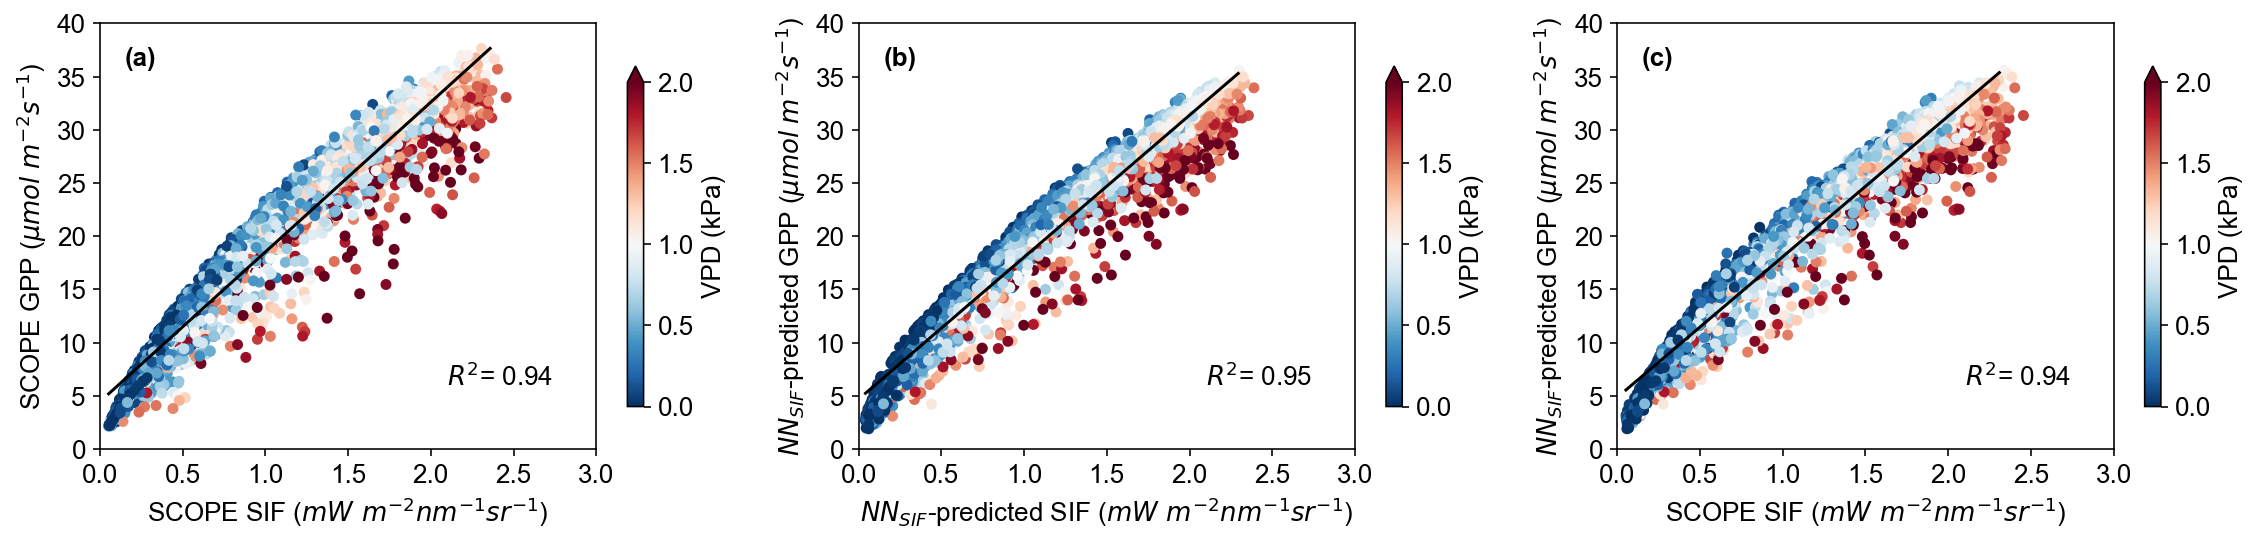

In [7]:
fig, axes = plt.subplots(figsize=(16,4),ncols=3)

xlim = [0,3]
ylim = [0,40]

GPP_SIF_dependence(day_SC,'SIFcanopy_760nm','GPP_canopy',xlim,ylim,axes[0],'VPD','RdBu_r',fig,'VPD (kPa)',s=20,vmin=0,vmax=2)
GPP_SIF_dependence(day_SC,'SIF_NN','GPP_NN',xlim,ylim,axes[1],'VPD','RdBu_r',fig,'VPD (kPa)',s=20,vmin=0,vmax=2) 
GPP_SIF_dependence(day_SC,'SIFcanopy_760nm','GPP_NN',xlim,ylim,axes[2],'VPD','RdBu_r',fig,'VPD (kPa)',s=20,vmin=0,vmax=2) 


xlabel = ['SCOPE SIF', '$NN_{SIF}$-predicted SIF', 'SCOPE SIF']
xunit  = [' ($mW \ m^{-2} nm^{-1} sr^{-1}$)']

ylabel = ['SCOPE GPP', '$NN_{SIF}$-predicted GPP', '$NN_{SIF}$-predicted GPP']
yunit = [' ($\mu mol$ $m^{-2} s^{-1}$)']
num_seq = ['(a)','(b)','(c)','(d)']
for i,ax in enumerate(axes):
    ax.set_xlabel(xlabel[i]+xunit[0])
    ax.set_ylabel(ylabel[i]+yunit[0])
    ax.annotate(num_seq[i],xy=(.05,.9), xycoords='axes fraction',fontweight='bold',fontsize=13)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.tight_layout()
